In [53]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [54]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [55]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [56]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [57]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [58]:
PassengerId = test['PassengerId']

In [59]:
full_data = [train, test]
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

In [60]:
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [61]:
# add new feature 'FamilySize' in train & test
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [62]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [63]:
def check_null_value(dataset):
    for i, s in enumerate(dataset.count()):
        if s != dataset.shape[0]:
            print('Column "{}" has {} of NULL value'.format(dataset.columns[i], dataset.shape[0] - s))

In [64]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [65]:
check_null_value(test)

Column "Age" has 86 of NULL value
Column "Fare" has 1 of NULL value
Column "Cabin" has 327 of NULL value


In [66]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [67]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5) 

In [68]:
check_null_value(train)
check_null_value(test)

Column "Cabin" has 687 of NULL value
Column "Cabin" has 327 of NULL value


In [69]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

In [70]:
train['Name'].apply(get_title)

0          Mr
1         Mrs
2        Miss
3         Mrs
4          Mr
5          Mr
6          Mr
7      Master
8         Mrs
9         Mrs
10       Miss
11       Miss
12         Mr
13         Mr
14       Miss
15        Mrs
16     Master
17         Mr
18        Mrs
19        Mrs
20         Mr
21         Mr
22       Miss
23         Mr
24       Miss
25        Mrs
26         Mr
27         Mr
28       Miss
29         Mr
        ...  
861        Mr
862       Mrs
863      Miss
864        Mr
865       Mrs
866      Miss
867        Mr
868        Mr
869    Master
870        Mr
871       Mrs
872        Mr
873        Mr
874       Mrs
875      Miss
876        Mr
877        Mr
878        Mr
879       Mrs
880       Mrs
881        Mr
882      Miss
883        Mr
884        Mr
885       Mrs
886       Rev
887      Miss
888      Miss
889        Mr
890        Mr
Name: Name, Length: 891, dtype: object

In [71]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [72]:
train[train['Name'].str.contains('Sir')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
60,61,0,3,"Sirayanian, Mr. Orsen",male,22,0,0,2669,7.2292,NaN,C,21,0,1,1,"(-0.001, 7.91]","(16.0, 32.0]",Mr
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49,1,0,PC 17485,56.9292,A20,C,44,1,2,0,"(31.0, 512.329]","(48.0, 64.0]",Sir
837,838,0,3,"Sirota, Mr. Maurice",male,24,0,0,392092,8.0500,NaN,S,19,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",Mr


In [73]:
# https://ja.wikipedia.org/wiki/%E3%82%B3%E3%82%BA%E3%83%A2%E3%83%BB%E3%83%80%E3%83%95%EF%BC%9D%E3%82%B4%E3%83%BC%E3%83%89%E3%83%B3_(%E7%AC%AC5%E4%BB%A3%E6%BA%96%E7%94%B7%E7%88%B5)#%E3%82%BF%E3%82%A4%E3%82%BF%E3%83%8B%E3%83%83%E3%82%AF%E5%8F%B7%E6%B2%88%E6%B2%A1%E4%BA%8B%E4%BB%B6
# Sir Cosmo Duff Gordon はタイタニック号から生還したが、事件後に批判に晒された。

In [74]:
for dataset in full_data:
    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    dataset['Title'] = dataset['Title'].replace(rare_titles, 'Rare')
    dataset['Title']= dataset['Title'].replace('Ms', 'Miss')

In [75]:
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0).astype(int)
    
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [76]:
# pandas.betweenもあるが、inclusiveをFalseにしても「left < target <= right」は表現できない。
train[train['Age'].between(16, 32)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title


In [83]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2


In [84]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

In [85]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


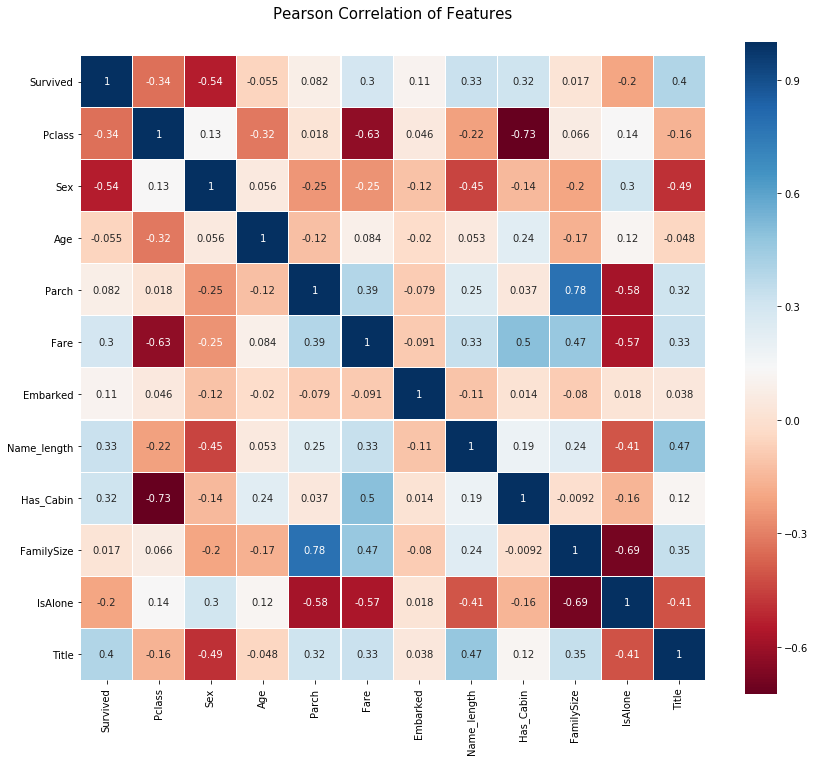

In [86]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [88]:
train.astype(float).corr()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
Survived,1.000000,-0.338481,-0.543351,-0.055470,0.081629,0.295875,0.106811,0.332350,0.316912,0.016639,-0.203367,0.396587
Pclass,-0.338481,1.000000,0.131900,-0.317610,0.018443,-0.628459,0.045702,-0.220001,-0.725541,0.065997,0.135207,-0.161368
Sex,-0.543351,0.131900,1.000000,0.055713,-0.245489,-0.248940,-0.116569,-0.448759,-0.140391,-0.200988,0.303646,-0.490517
Age,-0.055470,-0.317610,0.055713,1.000000,-0.121762,0.083529,-0.020169,0.052500,0.236281,-0.171037,0.120447,-0.048462
Parch,0.081629,0.018443,-0.245489,-0.121762,1.000000,0.393048,-0.078665,0.252282,0.036987,0.783111,-0.583398,0.318198
Fare,0.295875,-0.628459,-0.248940,0.083529,0.393048,1.000000,-0.091096,0.334176,0.497108,0.465815,-0.568942,0.330210
Embarked,0.106811,0.045702,-0.116569,-0.020169,-0.078665,-0.091096,1.000000,-0.107749,0.013774,-0.080281,0.017807,0.037587
Name_length,0.332350,-0.220001,-0.448759,0.052500,0.252282,0.334176,-0.107749,1.000000,0.190943,0.238820,-0.406800,0.473409
Has_Cabin,0.316912,-0.725541,-0.140391,0.236281,0.036987,0.497108,0.013774,0.190943,1.000000,-0.009175,-0.158029,0.118936
FamilySize,0.016639,0.065997,-0.200988,-0.171037,0.783111,0.465815,-0.080281,0.238820,-0.009175,1.000000,-0.690922,0.345017


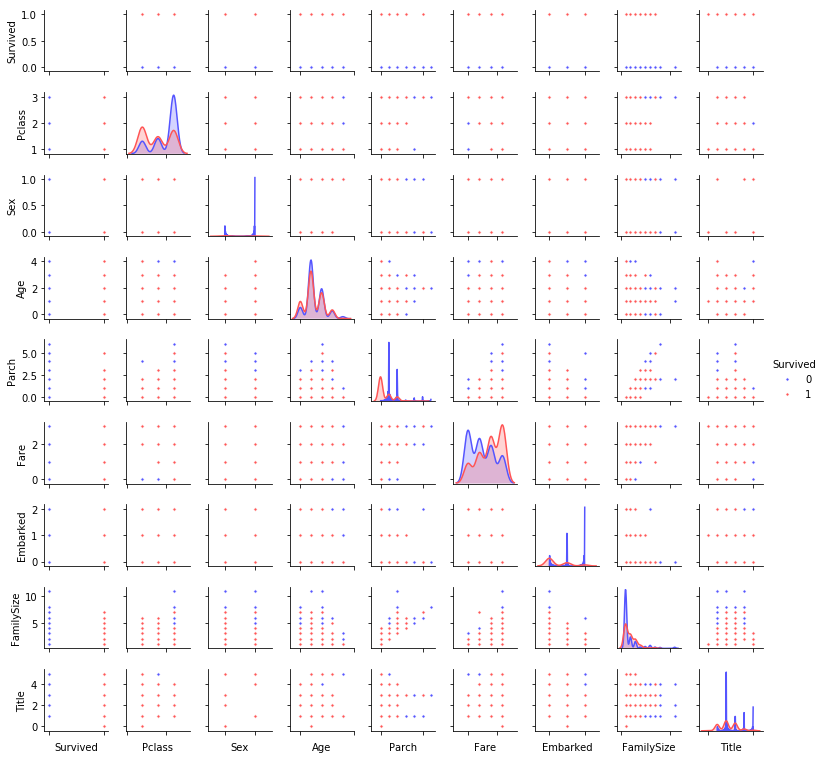

In [89]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
                       u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2,
                diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

In [91]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)

In [113]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

In [103]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [94]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [114]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [115]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

KeyError: 'Survived'

In [116]:
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

In [120]:
rf_features = rf.feature_importances(x_train, y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train, y_train)

In [129]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({'features': cols,
                          'Random Forest feature importances': rf_features,
                          'Extra Trees feature importances': et_features,
                          'AdaBoost feature importances': ada_features,
                          'Gradient Boost feature importances': gb_features})

In [134]:
# Scatter plot 
trace = go.Scatter(
    y=feature_dataframe['Random Forest feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color=feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text=feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth= 2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y=feature_dataframe['Extra Trees feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color=feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text=feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Extra Trees Feature Importance',
    hovermode='closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y=feature_dataframe['AdaBoost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color=feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text=feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='AdaBoost Feature Importance',
    hovermode='closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y=feature_dataframe['Gradient Boost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color=feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text=feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Gradient Boosting Feature Importance',
    hovermode='closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title='Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [137]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)

In [138]:
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.028,0.121031,0.068112,0.127447,Pclass,0.086148
1,0.010,0.393986,0.037357,0.209973,Sex,0.162829
2,0.026,0.030451,0.099289,0.031094,Age,0.046708
3,0.062,0.017511,0.035323,0.021096,Parch,0.033982
4,0.036,0.055688,0.104523,0.072823,Fare,0.067259
5,0.008,0.027702,0.055971,0.024625,Embarked,0.029075
6,0.684,0.048150,0.410721,0.107135,Name_length,0.312501
7,0.004,0.083601,0.019985,0.064648,Has_Cabin,0.043059
8,0.054,0.043230,0.074154,0.067235,FamilySize,0.059655
9,0.004,0.022664,0.022291,0.013248,IsAlone,0.015551


In [148]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(x=x,
              y=y,
              width=0.5,
              marker=dict(color=y,
                          colorscale='Portland',
                          showscale=True,
                          reversescale=False),
               opacity=0.6)]

layout = go.Layout(autosize=True,
                  title='Barplots of Mean Feature Importance',
                  hovermode='closest',
                  yaxis=dict(title='Feature Importance',
                            ticklen=5,
                            gridwidth=2),
                  showlegend=False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [149]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                      'ExtraTrees': et_oof_train.ravel(),
                                      'AdaBoost': ada_oof_train.ravel(),
                                      'GradientBoost': gb_oof_train.ravel()})

In [150]:
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [151]:
data = [go.Heatmap(z=base_predictions_train.astype(float).corr().values,
                  x=base_predictions_train.columns.values,
                  y=base_predictions_train.columns.values,
                  colorscale='Viridis',
                  showscale=True,
                  reversescale=True)]
py.iplot(data, filename='labelled-heatmap')

In [152]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [157]:
gbm = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1
).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [161]:
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId,
                                  'Survived': predictions})
StackingSubmission.to_csv('StackingSubmission.csv', index=False)

In [200]:
gbm.score(x_train, y_train)

0.8720538720538721